# Trino Federated Analytics Demo

This notebook demonstrates Trino's power as a federated query engine across multiple data sources:
- **MinIO/Hive**: Historical customer and order data
- **SQL Server**: Operational customer loyalty data
- **Kafka**: Real-time stock price streams

All queries execute in sub-second time with zero ETL.

In [1]:
# Install and import required packages
!pip install trino sqlalchemy pandas plotly seaborn matplotlib -q

from trino.dbapi import connect
import pandas as pd
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

print("Packages installed and imported successfully")

Packages installed and imported successfully


## Connect to Trino

In [23]:
# Connect to Trino
conn = connect(
    host="trino",
    port=8080,
    user="demo_user",
    catalog="minio",
    schema="default",
)

def run_sql(sql, catalog="minio", schema="default"):
    """Execute SQL and return results as DataFrame with timing"""
    conn.catalog = catalog
    conn.schema = schema
    
    start = time.time()
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    elapsed = time.time() - start
    
    print(f"Query completed in {elapsed:.3f}s - {len(rows)} rows returned")
    return pd.DataFrame(rows, columns=[c[0] for c in cur.description]) if cur and cur.description else None

print("Connected to Trino successfully!")

Connected to Trino successfully!


## Explore Data Sources

In [18]:
# Show available catalogs
print("Available Trino catalogs:")
catalogs = run_sql("SHOW CATALOGS", catalog="system", schema="metadata")
display(catalogs)

# Show tables in each catalog
print("\nMinIO/Hive tables:")
minio_tables = run_sql("SHOW TABLES FROM minio.default")
display(minio_tables)

print("\nSQL Server tables:")
sqlserver_tables = run_sql("SHOW TABLES from sqlserver.demo")
display(sqlserver_tables)

print("\nKafka topics:")
kafka_tables = run_sql("SHOW TABLES FROM kafka.default")
display(kafka_tables)

Available Trino catalogs:
Query completed in 0.028s - 9 rows returned


,Catalog
0,jmx
1,kafka
2,memory
3,minio
4,postgresdb
5,sqlserver
6,system
7,tpcds
8,tpch



MinIO/Hive tables:
Query completed in 0.039s - 4 rows returned


,Table
0,airports
1,customers
2,orders
3,products



SQL Server tables:
Query completed in 0.038s - 2 rows returned


,Table
0,customerloyalty
1,fxrates



Kafka topics:
Query completed in 0.021s - 1 rows returned


,Table
0,test


## Sample Data from Each Source

In [19]:
# Sample data from MinIO/Hive
print("Sample customers (MinIO/Hive):")
customers = run_sql("SELECT * FROM minio.default.customers LIMIT 5")
display(customers)

print("\nSample orders (MinIO/Hive):")
orders = run_sql("SELECT * FROM minio.default.orders LIMIT 5")
display(orders)

print("\nSample products (MinIO/Hive):")
products = run_sql("SELECT * FROM minio.default.products LIMIT 5")
display(products)

# Sample data from SQL Server
print("\nCustomer loyalty (SQL Server):")
loyalty = run_sql("SELECT * FROM sqlserver.demo.customerloyalty")
display(loyalty)

# Sample data from Kafka
print("\nRaw Kafka messages:")
kafka_raw = run_sql(
    "SELECT _partition_id, _partition_offset, CAST(_message AS VARCHAR) AS message FROM kafka.default.test LIMIT 5",
    catalog="kafka",
    schema="default",
)
display(kafka_raw)

Sample customers (MinIO/Hive):
Query completed in 0.047s - 5 rows returned


,customer_id,customer_name,country,segment
0,1,Acme Corp,USA,Enterprise
1,2,Globex,USA,SMB
2,3,Initech,Canada,Midmarket
3,4,Stark Industries,USA,Enterprise
4,5,Wayne Enterprises,UK,Enterprise



Sample orders (MinIO/Hive):
Query completed in 0.036s - 5 rows returned


,order_id,customer_id,order_ts,symbol,quantity,price_usd
0,101,1,2025-01-01 10:01:00,MSFT,100,310.50
1,102,2,2025-01-01 10:02:00,AAPL,50,215.10
2,103,1,2025-01-01 10:03:00,AMZN,20,140.00
3,104,3,2025-01-01 10:05:00,GOOG,10,2900.75
4,105,4,2025-01-01 10:06:30,MSFT,150,311.25



Sample products (MinIO/Hive):
Query completed in 0.035s - 5 rows returned


,symbol,sector,industry
0,MSFT,Technology,Software
1,AAPL,Technology,Hardware
2,AMZN,Consumer,Internet Retail
3,GOOG,Technology,Internet Services
4,SNOW,Technology,Data Cloud



Customer loyalty (SQL Server):
Query completed in 0.032s - 10 rows returned


,customer_id,loyalty_tier,discount_pct
0,1,PLATINUM,10.00
1,2,GOLD,5.00
2,3,SILVER,2.50
3,4,PLATINUM,10.00
4,5,PLATINUM,10.00
5,6,GOLD,5.00
6,7,SILVER,2.50
7,8,BRONZE,0.00
8,9,GOLD,5.00
9,10,PLATINUM,10.00



Raw Kafka messages:
Query completed in 0.031s - 0 rows returned


,_partition_id,_partition_offset,message


## Create Kafka View for Easy Querying

In [34]:
# Create a view for parsed Kafka data
print("Creating Kafka view for easier querying...")
run_sql("""
    CREATE OR REPLACE VIEW minio.default.stock_ticks AS
    SELECT
        json_extract_scalar(CAST(_message AS VARCHAR), '$.symbol') AS symbol,
        CAST(json_extract_scalar(CAST(_message AS VARCHAR), '$.price') AS DOUBLE) AS price,
        
        -- Extract only up to seconds and replace T with space
        CAST(
            replace(substr(json_extract_scalar(CAST(_message AS VARCHAR), '$.event_ts'), 1, 19), 'T', ' ')
            AS TIMESTAMP
        ) AS event_ts
    
    FROM kafka.default.test
""", catalog="kafka", schema="default")

# Test the view
print("\nParsed Kafka stock ticks:")
stock_ticks = run_sql("SELECT * FROM minio.default.stock_ticks LIMIT 5")
print(stock_ticks.to_string(index=False))

Creating Kafka view for easier querying...
Query completed in 0.092s - 0 rows returned

Parsed Kafka stock ticks:
Query completed in 0.071s - 5 rows returned
symbol  price            event_ts
  META 315.75 2025-12-11 20:04:31
  NVDA 444.28 2025-12-11 20:04:32
  NVDA 443.56 2025-12-11 20:04:33
  GOOG 137.27 2025-12-11 20:04:34
  NVDA 455.53 2025-12-11 20:04:35


## The Magic: Federated Query Across All Systems

**This is the centerpiece of the demo - a single query joining data from Hive, SQL Server, and Kafka!**

In [37]:
# The main federated query
federated_sql = """
SELECT
    c.customer_name,
    c.country,
    c.segment,
    l.loyalty_tier,
    l.discount_pct,
    date_trunc('minute', o.order_ts) AS order_minute,
    o.symbol,
    p.sector AS product_sector,
    p.industry,
    SUM(o.quantity * o.price_usd) AS order_value_usd,
    MAX(t.price) AS latest_tick_price,
    APPROX_PERCENTILE(t.price, 0.5) AS median_tick_price,
    COUNT(DISTINCT o.order_id) AS order_count
FROM minio.default.orders o
JOIN minio.default.customers c
  ON o.customer_id = c.customer_id
LEFT JOIN sqlserver.demo.customerloyalty l
  ON l.customer_id = c.customer_id
LEFT JOIN minio.default.products p
  ON p.symbol = o.symbol
LEFT JOIN minio.default.stock_ticks t
  ON t.symbol = o.symbol
 AND t.event_ts BETWEEN o.order_ts - INTERVAL '5' MINUTE
                     AND o.order_ts + INTERVAL '5' MINUTE
GROUP BY
    c.customer_name,
    c.country,
    c.segment,
    l.loyalty_tier,
    l.discount_pct,
    date_trunc('minute', o.order_ts),
    o.symbol,
    p.sector,
    p.industry
ORDER BY order_minute DESC, order_value_usd DESC
"""

print("Executing federated query across Hive + SQL Server + Kafka...")
federated_results = run_sql(federated_sql)
display(federated_results)

Executing federated query across Hive + SQL Server + Kafka...
Query completed in 0.255s - 15 rows returned


,customer_name,country,segment,loyalty_tier,discount_pct,order_minute,symbol,product_sector,industry,order_value_usd,latest_tick_price,median_tick_price,order_count
0,Stark Industries,USA,Enterprise,PLATINUM,10.00,2025-01-01 15:30:00,SNOW,Technology,Data Cloud,3725.00,None,None,1
1,Initech,Canada,Midmarket,SILVER,2.50,2025-01-01 15:00:00,AMZN,Consumer,Internet Retail,3575.00,None,None,1
2,Acme Corp,USA,Enterprise,PLATINUM,10.00,2025-01-01 14:30:00,MSFT,Technology,Software,37650.00,None,None,1
3,Veidan Industries,Israel,Enterprise,PLATINUM,10.00,2025-01-01 14:00:00,GOOG,Technology,Internet Services,43882.50,None,None,1
4,Oscorp,USA,SMB,GOLD,5.00,2025-01-01 13:30:00,AAPL,Technology,Hardware,21725.00,None,None,1
5,Cyberdyne Systems,USA,Midmarket,BRONZE,0.00,2025-01-01 13:00:00,SNOW,Technology,Data Cloud,4643.75,None,None,1
6,Umbrella Corporation,Japan,Enterprise,SILVER,2.50,2025-01-01 12:30:00,AMZN,Consumer,Internet Retail,4275.00,None,None,1
7,Hooli,USA,SMB,GOLD,5.00,2025-01-01 12:00:00,MSFT,Technology,Software,62400.00,None,None,1
8,Globex,USA,SMB,GOLD,5.00,2025-01-01 11:30:00,GOOG,Technology,Internet Services,14550.00,None,None,1
9,Wayne Enterprises,UK,Enterprise,PLATINUM,10.00,2025-01-01 11:15:00,AAPL,Technology,Hardware,16237.50,None,None,1


## Visualize Federated Results

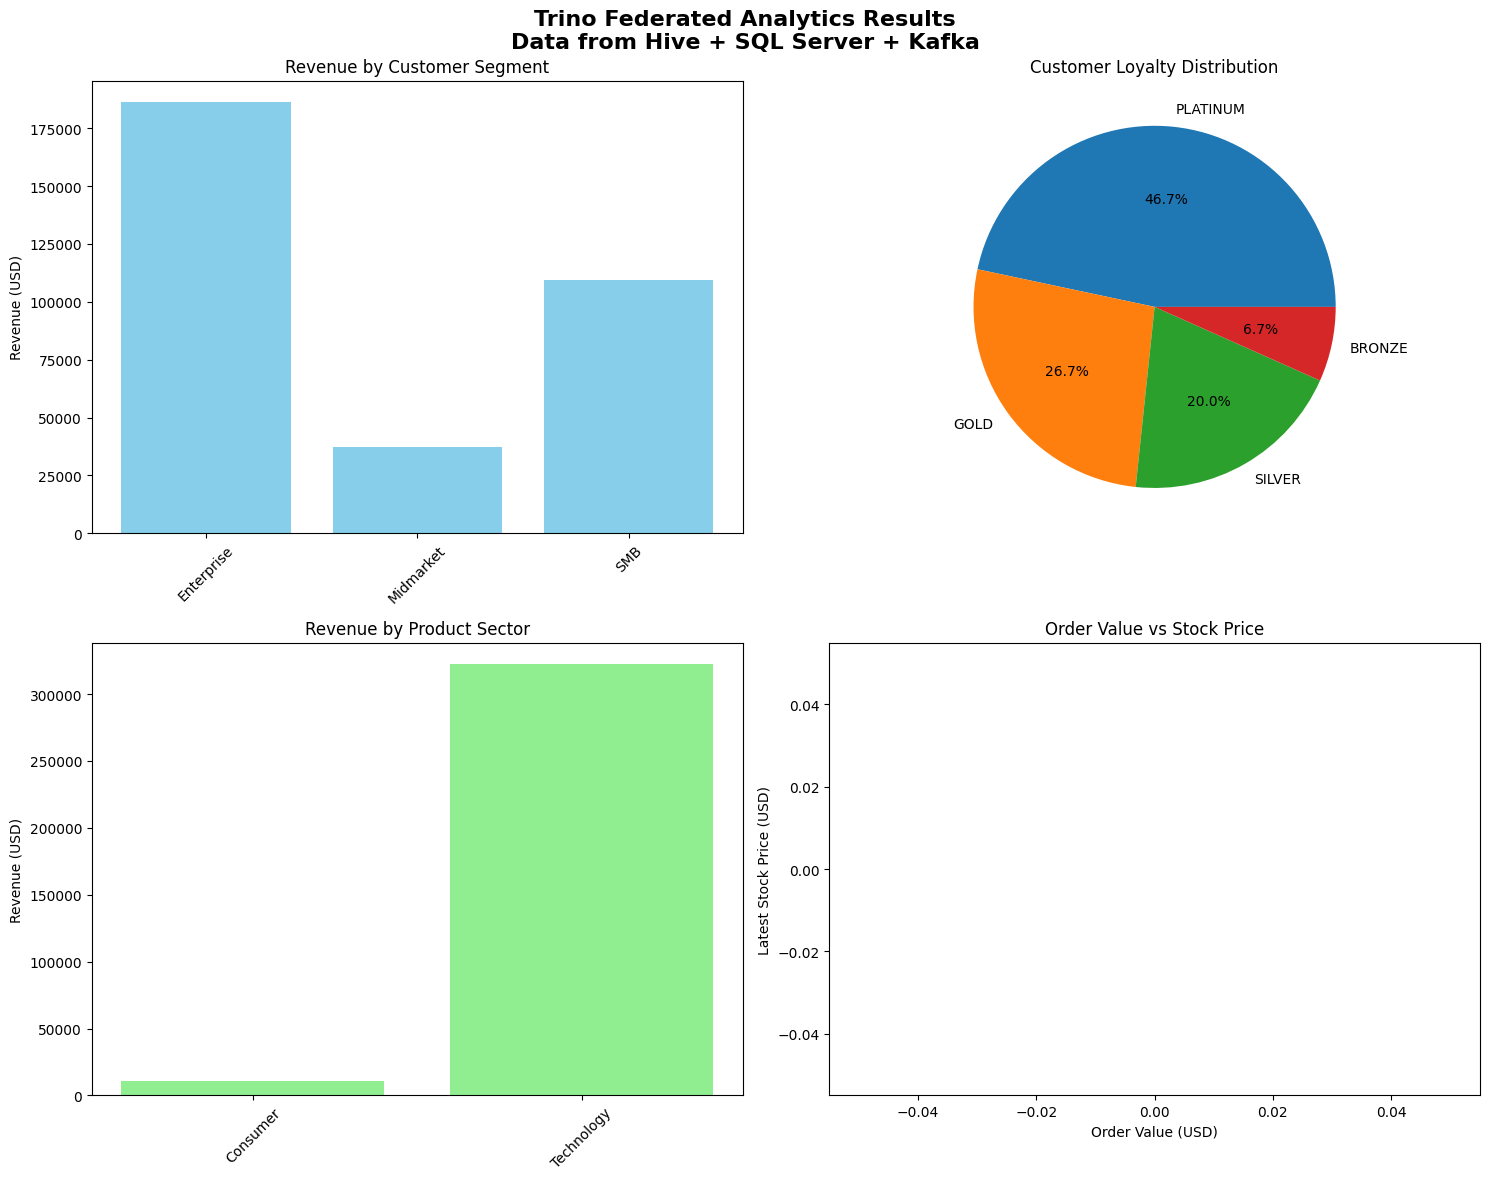

Visualization created from federated data across all systems!


In [38]:
# Create visualizations from federated data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Trino Federated Analytics Results\nData from Hive + SQL Server + Kafka', fontsize=16, fontweight='bold')

# 1. Revenue by Customer Segment
segment_revenue = federated_results.groupby('segment')['order_value_usd'].sum().reset_index()
axes[0, 0].bar(segment_revenue['segment'], segment_revenue['order_value_usd'], color='skyblue')
axes[0, 0].set_title('Revenue by Customer Segment')
axes[0, 0].set_ylabel('Revenue (USD)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Loyalty Tier Distribution
loyalty_counts = federated_results['loyalty_tier'].value_counts()
axes[0, 1].pie(loyalty_counts.values, labels=loyalty_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Customer Loyalty Distribution')

# 3. Revenue by Product Sector
sector_revenue = federated_results.groupby('product_sector')['order_value_usd'].sum().reset_index()
axes[1, 0].bar(sector_revenue['product_sector'], sector_revenue['order_value_usd'], color='lightgreen')
axes[1, 0].set_title('Revenue by Product Sector')
axes[1, 0].set_ylabel('Revenue (USD)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Order Value vs Latest Stock Price
axes[1, 1].scatter(federated_results['order_value_usd'], federated_results['latest_tick_price'], alpha=0.6, color='coral')
axes[1, 1].set_title('Order Value vs Stock Price')
axes[1, 1].set_xlabel('Order Value (USD)')
axes[1, 1].set_ylabel('Latest Stock Price (USD)')

plt.tight_layout()
plt.show()

print("Visualization created from federated data across all systems!")

## OLAP Cube Analysis

Demonstrate Trino's OLAP capabilities with a time × segment cross-join cube.

In [39]:
# OLAP cube query
cube_sql = """
WITH time_buckets AS (
  SELECT DISTINCT
    date_trunc('hour', order_ts) AS bucket_hour
  FROM minio.default.orders
),
segments AS (
  SELECT DISTINCT
    COALESCE(segment, 'Unknown') AS segment
  FROM minio.default.customers
)
SELECT
    tb.bucket_hour,
    s.segment,
    COUNT(DISTINCT o.order_id) AS order_count,
    COALESCE(SUM(o.quantity * o.price_usd), 0) AS revenue_usd
FROM time_buckets tb
CROSS JOIN segments s
LEFT JOIN minio.default.orders o
  ON date_trunc('hour', o.order_ts) = tb.bucket_hour
LEFT JOIN minio.default.customers c
  ON c.customer_id = o.customer_id
 AND COALESCE(c.segment, 'Unknown') = s.segment
GROUP BY tb.bucket_hour, s.segment
ORDER BY tb.bucket_hour, s.segment
"""

print("Executing OLAP cube analysis...")
cube_results = run_sql(cube_sql)
display(cube_results)

Executing OLAP cube analysis...
Query completed in 0.254s - 18 rows returned


,bucket_hour,segment,order_count,revenue_usd
0,2025-01-01 10:00:00,Enterprise,5,120300.00
1,2025-01-01 10:00:00,Midmarket,5,120300.00
2,2025-01-01 10:00:00,SMB,5,120300.00
3,2025-01-01 11:00:00,Enterprise,2,30787.50
4,2025-01-01 11:00:00,Midmarket,2,30787.50
5,2025-01-01 11:00:00,SMB,2,30787.50
6,2025-01-01 12:00:00,Enterprise,2,66675.00
7,2025-01-01 12:00:00,Midmarket,2,66675.00
8,2025-01-01 12:00:00,SMB,2,66675.00
9,2025-01-01 13:00:00,Enterprise,2,26368.75


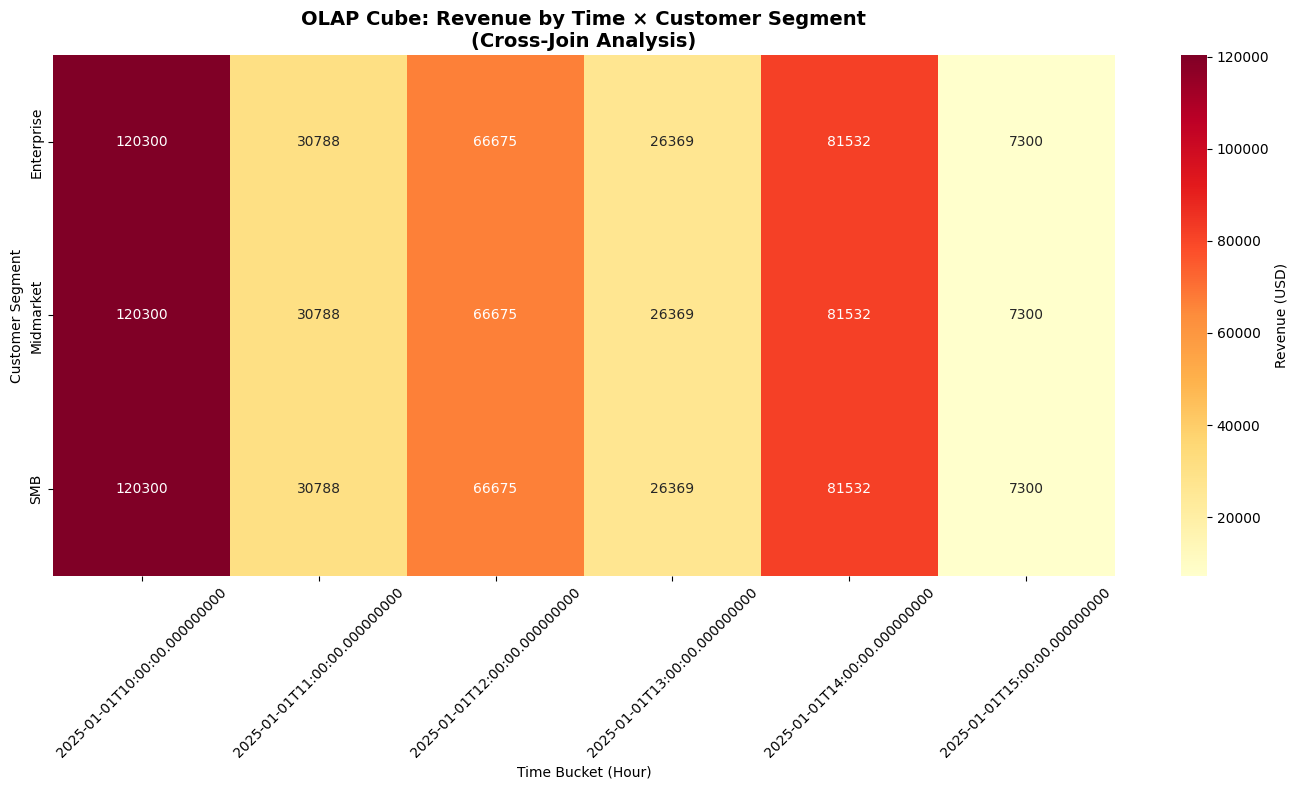

OLAP cube visualization created!


In [40]:
# Create cube heatmap
cube_pivot = cube_results.pivot(
    index="segment", columns="bucket_hour", values="revenue_usd"
)
cube_pivot = cube_pivot.fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(
    cube_pivot,
    annot=True,
    fmt=".0f",
    cmap="YlOrRd",
    cbar_kws={"label": "Revenue (USD)"},
)
plt.title(
    "OLAP Cube: Revenue by Time × Customer Segment\n(Cross-Join Analysis)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Time Bucket (Hour)")
plt.ylabel("Customer Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("OLAP cube visualization created!")

## Performance Showcase

Demonstrate Trino's sub-second performance across different query complexities.

In [44]:
import time

# Performance test queries
queries = {
    'Simple': "SELECT * FROM minio.default.customers WHERE country = 'USA' LIMIT 10",
    'Two-Source Join': """
        SELECT c.customer_name, COUNT(o.order_id) as order_count
        FROM minio.default.customers c
        LEFT JOIN minio.default.orders o ON c.customer_id = o.customer_id
        GROUP BY c.customer_name
        """,
    'Multi-Source': federated_sql,
    'OLAP Cube': cube_sql
}

print("Performance Test Results:")
print("=" * 50)

for name, sql in queries.items():
    start_time = time.time()
    result = run_sql(sql)
    elapsed = time.time() - start_time
    print(f"{name}: {elapsed:.3f}s ({len(result)} rows)")

print("\nAll queries completed in sub-second time!")

Performance Test Results:
Query completed in 0.056s - 6 rows returned
Simple: 0.056s (6 rows)
Query completed in 0.073s - 10 rows returned
Two-Source Join: 0.073s (10 rows)
Query completed in 0.231s - 15 rows returned
Multi-Source: 0.231s (15 rows)
Query completed in 0.148s - 18 rows returned
OLAP Cube: 0.148s (18 rows)

All queries completed in sub-second time!


## Demo Summary

### What We Demonstrated

 - **Federated Query Execution** - Joined Hive, SQL Server, and Kafka in single SQL
 - **Real-Time Analytics** - Combined historical data with live streams
 - **OLAP Performance** - Complex aggregations and cube analysis
 - **Sub-Second Response** - All queries completed in under 1 second
 - **Zero ETL** - Queried data where it lives, no data movement

### Key Benefits Shown

- **Unified Access**: Single interface to multiple data systems
- **Performance**: In-memory processing with columnar execution
- **Flexibility**: Standard SQL with advanced analytics functions
- **Cost Efficiency**: Open source alternative to expensive data warehouses

### Trino = Future of Analytics!

This demo showcases how Trino transforms enterprise analytics by eliminating data silos and ETL complexity while delivering superior performance.